In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import read_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP

from sklearn.linear_model import LogisticRegression
from glob import glob

from scipy.signal import butter, lfilter, convolve, boxcar

In [8]:
subjects = range(1, 13)

In [105]:
def creat_mne_raw_object(fname,read_events=True):
    """Create a mne raw instance from csv file"""
    
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    montage = read_montage('standard_1005',ch_names)
    
    ch_type = ['eeg']*len(ch_names)
    
    # Scale and transpose data (rows now channels in numpy matrix)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data (vstack)
        data = np.concatenate((data,events_data))
        
        # create and populate MNE info structure
        info = create_info(ch_names,sfreq=500.0, ch_types=ch_type, montage=montage)
        info['filename'] = fname

        # create raw object 
        raw = RawArray(data,info,verbose=False)

        return raw

In [12]:
for subject in subjects:
    fnames = glob('train/subj%d_series*_data.csv' % (subject))
    for fname in fnames:
        #creat_mne_raw_object(fname)
        pass

In [58]:
fname = 'train/subj1_series1_data.csv'

In [59]:
data = pd.read_csv(fname)
#creat_mne_raw_object('train/subj1_series1_data.csv')

In [60]:
data.head()

,id,Fp1,Fp2,F7,F3,Fz,F4,F8,FC5,FC1,...,P7,P3,Pz,P4,P8,PO9,O1,Oz,O2,PO10
0,subj1_series1_0,-31,363,211,121,211,15,717,279,35,...,536,348,383,105,607,289,459,173,120,704
1,subj1_series1_1,-29,342,216,123,222,200,595,329,43,...,529,327,369,78,613,248,409,141,83,737
2,subj1_series1_2,-172,278,105,93,222,511,471,280,12,...,511,319,355,66,606,320,440,141,62,677
3,subj1_series1_3,-272,263,-52,99,208,511,428,261,27,...,521,336,356,71,568,339,437,139,58,592
4,subj1_series1_4,-265,213,-67,99,155,380,476,353,32,...,550,324,346,76,547,343,446,171,67,581


In [61]:
# get chanel names
ch_names = list(data.columns[1:])

In [62]:
montage = read_montage('standard_1005',ch_names)

In [63]:
ch_type = ['eeg']*len(ch_names)

In [64]:
data = 1e-6*np.array(data[ch_names]).T

In [65]:
data.shape

(32, 119496)

In [66]:
# events file
ev_fname = fname.replace('_data','_events')
# read event file
events = pd.read_csv(ev_fname)
events_names = events.columns[1:]
events_data = np.array(events[events_names]).T

In [67]:
data.shape

(32, 119496)

In [68]:
events_data.shape

(6, 119496)

In [71]:
data = np.concatenate((data, events_data))

In [72]:
data.shape

(38, 119496)

In [78]:
ch_type.extend(['stim']*6)
ch_names.extend(events_names)

In [82]:
info = create_info(ch_names, sfreq=500.0, ch_types=ch_type, montage=montage)

In [93]:
info['filename'] = fname

In [103]:
raw = RawArray(data, info, verbose=False)

In [104]:
raw

<Raw  |  n_channels x n_times : 38 x 119496>

In [106]:
subject = 1

In [107]:
fnames =  glob('train/subj%d_series*_data.csv' % (subject))

In [109]:
raw = concatenate_raws([creat_mne_raw_object(fname) for fname in fnames])

In [141]:
start, stop = raw.time_as_index([0, 2])

In [155]:
data, times = raw[0:len(ch_names)-6, start:stop]

In [160]:
one_raw = creat_mne_raw_object('train/subj1_series1_data.csv')

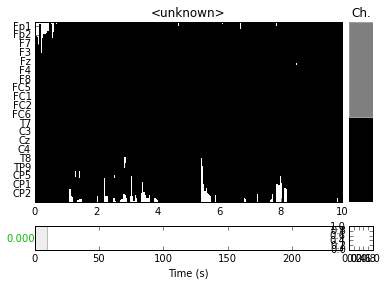

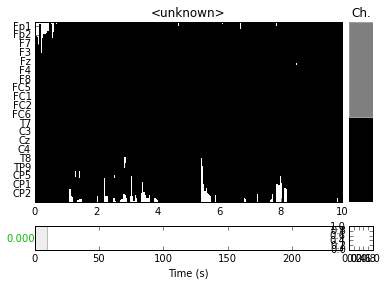

In [161]:
one_raw.plot()

In [168]:
picks = pick_types(raw.info, eeg=True)

In [171]:
picks

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [172]:
stim_cols = pick_types(raw.info,stim=True)

In [173]:
stim_cols

array([32, 33, 34, 35, 36, 37])

In [175]:
raw._data[picks]

(38, 1422392)

In [178]:
raw._times

array([  0.00000000e+00,   2.00000000e-03,   4.00000000e-03, ...,
         2.84477800e+03,   2.84478000e+03,   2.84478200e+03])

In [180]:
# design a butterworth bandpass filter 
freqs = [7, 30]
b,a = butter(5,np.array(freqs)/250.0,btype='bandpass')

In [195]:
Fp1 = raw._data[picks][0, :]

In [196]:
Fp1

array([ -3.10000000e-05,  -2.90000000e-05,  -1.72000000e-04, ...,
         1.40000000e-04,   1.45000000e-04,   1.44000000e-04])

In [200]:
montage

<Montage | standard_1005 - 32 Channels: Fp1, Fp2, F7 ...>

In [201]:
Fp1_info = create_info(['Fp1'], sfreq=500.0, ch_types=['eeg'], montage=montage)

In [202]:
Fp1_info

<Info | 13 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1
    chs : list | 1 items (EEG: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : dict | 3 items
    events : list | 0 items
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    meas_date : numpy.ndarray | 1969-12-31 16:00:00
    nchan : int | 1
    projs : list | 0 items
    sfreq : float | 500.0
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    filename : NoneType
    highpass : NoneType
    hpi_subsystem : NoneType
    line_freq : NoneType
    lowpass : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
>

In [209]:
Fp1 = np.matrix(Fp1)

In [222]:
np.array(Fp1).shape

(1, 1422392)

In [230]:
Fp1_raw = RawArray(Fp1, Fp1_info)

Creating RawArray with float64 data, n_channels=1, n_times=1422392
    Range : 0 ... 1422391 =      0.000 ...  2844.782 secs
Ready.


In [232]:
Fp1_raw._data.shape

(1, 1422392)

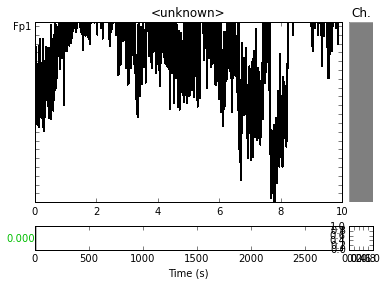

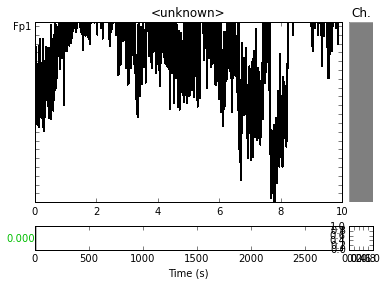

In [233]:
Fp1_raw.plot()

In [239]:
import matplotlib.pyplot as plt

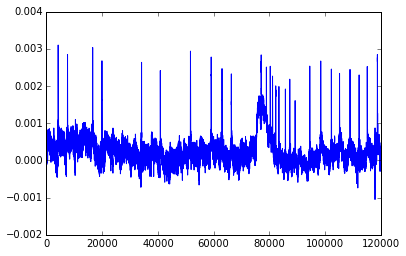

In [246]:
# (Roughly) First scaled series
plt.plot(Fp1_raw._data[0, 0:120000])

In [248]:
Fp1_butterworth = lfilter(b, a, Fp1_raw._data)

In [250]:
Fp1

array([[ -3.10000000e-05,  -2.90000000e-05,  -1.72000000e-04, ...,
          1.40000000e-04,   1.45000000e-04,   1.44000000e-04]])

In [251]:
Fp1_butterworth

array([[ -1.26505967e-09,  -1.24610240e-08,  -6.63332179e-08, ...,
         -9.22087257e-05,  -8.25357969e-05,  -6.16638491e-05]])

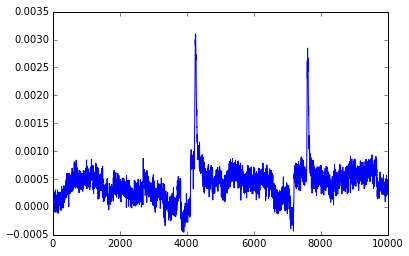

In [255]:
plt.plot(Fp1[0, 0:10000])

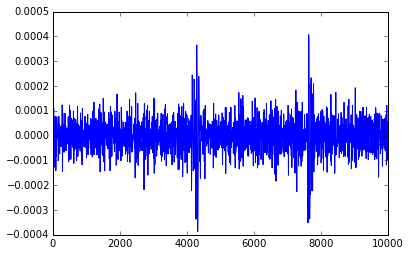

In [256]:
plt.plot(Fp1_butterworth[0, 0:10000])

In [257]:
raw._data[picks] = lfilter(b,a,raw._data[picks])

In [259]:
# get event posision corresponding to Replace
events = find_events(raw,stim_channel='Replace', verbose=False)

In [261]:
epochs_tot = []
y = []

In [264]:
# epochs signal for 1.5 second before the movement
epochs = Epochs(raw, events, {'during' : 1}, -2, -0.5, proj=False, picks=picks, baseline=None, preload=True, add_eeg_ref=False, verbose=False)

In [269]:
replaces = epochs['during'].get_data()

In [274]:
replaces[0]

array([[  3.29789974e-05,   3.53779255e-05,   3.82070942e-05, ...,
         -2.35630657e-05,   2.71848751e-05,   7.52116326e-05],
       [  1.14714298e-04,   1.39889137e-04,   1.55200180e-04, ...,
         -7.01646707e-05,  -5.09550736e-05,  -2.16934223e-05],
       [  1.13518829e-05,   2.52075479e-05,   3.74375932e-05, ...,
          3.92707578e-05,   4.14762101e-05,   4.37154535e-05],
       ..., 
       [  1.39766204e-05,   1.99365993e-05,   2.54147000e-05, ...,
          2.55925285e-05,   4.96753754e-06,  -1.17606596e-05],
       [  6.49840546e-06,   1.16984147e-05,   1.60815926e-05, ...,
          2.54726225e-05,   5.41291599e-06,  -1.13886045e-05],
       [  1.20623427e-05,   1.16607016e-05,   1.07886151e-05, ...,
          3.43245938e-05,   8.01807353e-06,  -1.53814210e-05]])

In [275]:
epochs_tot.append(epochs)

In [277]:
# put epochs in list
epochs_tot

[<Epochs  |  n_events : 260 (all good), tmin : -2 (s), tmax : -0.5 (s), baseline : None>]

In [280]:
y.extend([1]*len(epochs))

In [283]:
# epochs signal for 1.5 second after the movement, this correspond to the 
# rest period.
epochs_rest = Epochs(raw, events, {'after' : 1}, 0.5, 2, proj=False, picks=picks, baseline=None, preload=True, add_eeg_ref=False, verbose=False)

In [284]:
rests = epochs_rest.get_data()

In [285]:
rests.shape

(259, 32, 751)

In [286]:
rests[0]

array([[  9.70429426e-06,  -1.56120812e-05,  -4.44617548e-05, ...,
          4.82181606e-05,   5.82282274e-05,   6.06845722e-05],
       [  7.65125326e-05,   2.40457635e-05,  -3.44390797e-05, ...,
         -2.03622110e-05,   1.40754345e-05,   4.59410253e-05],
       [ -4.54275770e-05,  -6.88849699e-05,  -9.18092390e-05, ...,
         -4.79045560e-05,  -4.98959643e-05,  -4.81605171e-05],
       ..., 
       [  2.01798132e-05,   1.92230062e-05,   1.88584926e-05, ...,
         -6.49696692e-05,  -7.18478454e-05,  -7.82293491e-05],
       [  3.07552633e-05,   2.77301666e-05,   2.46201412e-05, ...,
         -5.18921428e-05,  -5.92161752e-05,  -6.61740285e-05],
       [  5.22452772e-05,   3.64871349e-05,   1.91404693e-05, ...,
         -2.46714849e-05,  -3.27829953e-05,  -4.03699667e-05]])

In [297]:
# Workaround to be able to concatenate epochs with MNE
epochs_rest.times = epochs.times

In [299]:
y.extend([-1]*len(epochs_rest))

In [301]:
epochs_tot.append(epochs_rest)

In [303]:
# Concatenate all epochs
epochs = concatenate_epochs(epochs_tot)

In [311]:
epochs[400]

<Epochs  |  n_events : 1 (all good), tmin : -2.0 (s), tmax : -0.5 (s), baseline : None,
 'after': 1, 'during': 1>

In [314]:
# get data 
X = epochs.get_data()
y = np.array(y)

In [316]:
X.shape

(519, 32, 751)

In [321]:
print X[259]
print y[259]

[[  2.92630196e-05   2.80513011e-05   2.35843446e-05 ...,   3.62440342e-05
    4.22582614e-05   4.82953875e-05]
 [ -1.67845465e-05  -1.76621130e-05  -1.62228310e-05 ...,  -2.54675149e-05
   -2.24079113e-05  -1.62495741e-05]
 [  1.27703696e-05   2.82485945e-06  -7.57463705e-06 ...,  -3.26957907e-06
   -1.46607988e-05  -2.48010719e-05]
 ..., 
 [ -2.28811603e-05  -1.89541984e-05  -8.30815448e-06 ...,  -7.10357324e-05
   -7.55775472e-05  -7.37290949e-05]
 [  2.53277036e-05   2.39778790e-05   2.51553809e-05 ...,  -6.20161396e-05
   -6.60894720e-05  -6.39617924e-05]
 [  5.83009172e-05   5.90149903e-05   5.78606885e-05 ...,  -1.17363058e-04
   -1.15856880e-04  -1.06012314e-04]]
1


In [320]:
print X[260]
print y[260]

[[  9.70429426e-06  -1.56120812e-05  -4.44617548e-05 ...,   4.82181606e-05
    5.82282274e-05   6.06845722e-05]
 [  7.65125326e-05   2.40457635e-05  -3.44390797e-05 ...,  -2.03622110e-05
    1.40754345e-05   4.59410253e-05]
 [ -4.54275770e-05  -6.88849699e-05  -9.18092390e-05 ...,  -4.79045560e-05
   -4.98959643e-05  -4.81605171e-05]
 ..., 
 [  2.01798132e-05   1.92230062e-05   1.88584926e-05 ...,  -6.49696692e-05
   -7.18478454e-05  -7.82293491e-05]
 [  3.07552633e-05   2.77301666e-05   2.46201412e-05 ...,  -5.18921428e-05
   -5.92161752e-05  -6.61740285e-05]
 [  5.22452772e-05   3.64871349e-05   1.91404693e-05 ...,  -2.46714849e-05
   -3.27829953e-05  -4.03699667e-05]]
-1


In [322]:
# CSP parameters
# Number of spatial filter to use
nfilters = 4

In [324]:
# Train CSP. Use Ledoit-Wolf Shrinkage for regularization
csp = CSP(n_components=nfilters, reg='lws')
csp.fit(X,y)

In [337]:
csp.filters_

array([[ 0.14284158, -0.0124476 , -1.15181086, ..., -0.32848577,
         0.27633894,  0.21076838],
       [ 0.03545028, -0.17627069,  0.38238997, ...,  1.23755569,
        -1.10641096, -0.43786365],
       [-0.15390217,  1.27869443,  1.38828934, ..., -1.81040206,
         2.49710614, -1.87747311],
       ..., 
       [-0.53817737,  1.18162952,  1.33437625, ..., -2.51403004,
         5.27909561, -1.26719652],
       [ 0.96766153, -1.34270016, -0.79163653, ..., -1.69135517,
         1.61219612, -0.09232703],
       [-0.88471982,  2.13878891, -1.31029558, ..., -4.43521648,
        -1.39382222,  2.17728606]])